# Reinforcement Learning Group Project

Author: Kim Isabella Zierahn, 6635183


This notebook documents my contributions and code to the group project. It contains checkpoints, thoughts, code snippets, where I tried out things, and plots.


## Checkpoint 1: Get your algorithms up and running

I am comparing three PPO models that get increasingly optimized. The performance is tested on simple environments to determine the best working algorithm out of the three. For continous actions, I am using the Pendulum and HalfCheetah from the OpenAI Gym.

I am comparing five PPO models that get increasingly optimized:

| Model       | Training phases   | Surrogate objective                                                              | Policy parameterization |
|-------------|-------------------|----------------------------------------------------------------------------------|------------------------|
| Vanilla PPO | Policy phase only | Clipped surrogate objective                                                      | Normal distribution|
| PPG         | Policy phase + auxiliary phase | Clipped surrogate objective + behavioral cloning loss + arbitrary auxiliary loss | Normal distribution|
| PPG KL      | Policy phase + auxiliary phase | Reversed KL divergence + behavioral cloning loss + arbitrary auxiliary loss | Normal distribution|
| PPG Beta    | Policy phase + auxiliary phase | Clipped surrogate objective + behavioral cloning loss + arbitrary auxiliary loss | Beta distribution|
| PPG KL Beta | Policy phase + auxiliary phase | Reversed KL divergence + behavioral cloning loss + arbitrary auxiliary loss | Beta distribution|


In [1]:
import gymnasium as gym
import numpy as np
import random
import matplotlib.pyplot as plt
import hockey.hockey_env as h_env
from hockey.hockey_env import Mode

### Continuous Action Space: Pendulum

In [2]:
env_pend = gym.make("Pendulum-v1")
state_dim = env_pend.observation_space.shape[0]
action_dim = env_pend.action_space.shape[0]

#### Vanilla PPO

This is the standard unmodified **vanilla PPO** algorithm that I take as a base comparison.

**Source:** The basis of this PPO base algorithm comes from: University of Tübingen, Autonomous Learning, Reinforcement Learning Lecture 8: "PPO_08_solution.py"

In [3]:
from src.PPO import PPO

ppo_vanilla = PPO(
    state_dim,
    action_dim,
    n_latent_var = 128,
    lr = 0.003,
    betas = (0.9, 0.999),
    gamma = 0.99,
    K_epochs = 10,
    eps_clip = 0.25,
    has_continuous_action_space = True,
    action_std_init = 0.5
)

#### PPG

This is a **PPG** algorithm, a modified version of PPO. It consists of two training phases: a policy phase and an additional **periodic auxiliary phase**. During the policy phase, we are training the agent with vanilla PPO, optimizing the clipped surrogate objective. During the auxiliary phase, we distill features from the value function into the policy network

In [4]:
from src.PPG import PPO

ppg = PPO(
    state_dim,
    action_dim,
    n_latent_var_actor = 128,
    n_latent_var_critic = 128,
    network_depth_actor = 1,
    network_depth_critic = 1,
    has_continuous_action_space = True,
    action_std_init = 0.5,
    lr = 0.003,
    betas = (0.9, 0.999),
    gamma = 0.99,
    K_epochs = 10,
    eps_clip = 0.25,
    c1 = 0.5,
    c2 = 0.01,
    beta_clone = 0.95
)

#### PPG with KL divergence

This is a PPG algorithm using a **reversed KL divergence** for regularization instead of a clipped objective. It uses a soft constraint on the reversed KL distance between
the initial and the updated policy.

In [5]:
from src.PPG_KL import PPO

ppg_kl = PPO(
    state_dim,
    action_dim,
    n_latent_var_actor = 128,
    n_latent_var_critic = 128,
    network_depth_actor = 1,
    network_depth_critic = 1,
    has_continuous_action_space = True,
    action_std_init = 0.5,
    lr = 0.003,
    betas = (0.9, 0.999),
    gamma = 0.99,
    K_epochs = 10,
    eps_clip = 0.25,
    c1 = 0.5,
    c2 = 0.01,
    beta_clone = 0.95
)

#### PPG with Beta distribution

This is a PPG algorithm with a **Beta distribution** for policy parameterization instead of a Normal distribution. It is an optimized version of PPG, where we are using a Beta distribution for the action space and initializing the weights of the policy network with the weights of the value network.

In [6]:
from src.PPG_Beta import PPO

ppg_beta = PPO(
    state_dim,
    action_dim,
    n_latent_var_actor = 128,
    n_latent_var_critic = 128,
    network_depth_actor = 1,
    network_depth_critic = 1,
    has_continuous_action_space = True,
    action_std_init = 0.5,
    lr = 0.003,
    betas = (0.9, 0.999),
    gamma = 0.99,
    K_epochs = 10,
    eps_clip = 0.25,
    c1 = 0.5,
    c2 = 0.01,
    beta_clone = 0.95
)

#### PPG with KL divergence and Beta distribution

This is a PPG algorithm using a **reversed KL divergence** for the loss and a **Beta distribution** for policy parameterization.

In [7]:
from src.PPG_KL_Beta import PPO

ppg_kl_beta = PPO(
    state_dim,
    action_dim,
    n_latent_var_actor = 128,
    n_latent_var_critic = 128,
    network_depth_actor = 1,
    network_depth_critic = 1,
    has_continuous_action_space = True,
    action_std_init = 0.5,
    lr = 0.003,
    betas = (0.9, 0.999),
    gamma = 0.99,
    K_epochs = 10,
    eps_clip = 0.25,
    c1 = 0.5,
    c2 = 0.01,
    beta_clone = 0.95
)

#### Comparison of Training Behavior

In [8]:
# Training loop
def train_pendulum_ppo(env, max_episodes, max_timesteps, update_timestep, agent):
    memory = Memory()
    timestep = 0
    episode_rewards = []

    print("Agent: ", agent)

    for episode in range(max_episodes):
        state, _ = env.reset()
        state = state.flatten()
        episode_reward = 0

        for t in range(max_timesteps):
            timestep += 1

            # Sample action
            action = agent.policy_old.act(state, memory)
            state, reward, done, _, _ = env.step(action)
            state = state.flatten()

            # Save reward and terminal state
            memory.rewards.append(reward)
            memory.is_terminals.append(done)

            episode_reward += reward

            if done:
                break

        # Update PPO if it's time
        if timestep % update_timestep == 0:
            agent.update(memory)
            memory.clear_memory()
            timestep = 0

        if episode % 50 == 0:
            print(f"Episode {episode + 1}, Reward: {episode_reward}")

        episode_rewards.append(episode_reward)

    return episode_rewards

In [9]:
# Training loop
def train_pendulum_ppg(env, max_episodes, max_timesteps, update_timestep, agent):
    memory = Memory()
    episode_rewards = []
    timestep = 0

    print("Agent: ", agent)

    for episode in range(max_episodes):
        state, _ = env.reset()
        state = state.flatten()
        episode_reward = 0
        done = False

        for t in range(max_timesteps):
            timestep += 1
            # Sample action
            action = agent.policy_old.act(state, memory)
            state, reward, done, _, _ = env.step(action)

            # Save reward and terminal state
            memory.rewards.append(reward)
            memory.is_terminals.append(done)

            episode_reward += reward

            if done:
                break

        # Update PPO if it's time
        if episode % update_timestep == 0:
            agent.update(memory)
            memory.clear_memory()

        # Auxiliary phase: Train value function
        if episode % 50 == 0:
            agent.auxiliary_phase(memory)
            print(f"Episode {episode + 1}, Reward: {episode_reward}")

        episode_rewards.append(episode_reward)

    return episode_rewards

In [10]:
# Train each model for 1000 episodes
max_eps = 5000
max_tsteps = 500
upd_tsteps = 100

rewards_ppo = np.load("../dat/pendulum/rewards_ppo_pendulum.npy")
# rewards_ppg = train_pendulum_ppg(env_pend, max_eps, max_tsteps, upd_tsteps, ppg)
# rewards_ppg_kl = train_pendulum_ppg(env_pend, max_eps, max_tsteps, upd_tsteps, ppg_kl)
# rewards_ppg_beta = train_pendulum_ppg(env_pend, max_eps, max_tsteps, upd_tsteps, ppg_beta)
# rewards_ppg_kl_beta = train_pendulum_ppg(env_pend, max_eps, max_tsteps, upd_tsteps, ppg_kl_beta)

Agent:  <PPG.PPO object at 0x12382b550>
Episode 1, Reward: -2130.687873464667
Episode 51, Reward: -4106.502238249007


KeyboardInterrupt: 

In [ ]:
# Load rewards
rewards_ppo_pendulum = np.load("../dat/cheetah/rewards_ppo_pendulum.npy")
# rewards_ppg_pendulum = np.load("cluster/pendulum/rewards_ppg_pendulum.npy")
# rewards_ppg_kl_pendulum = np.load("cluster/pendulum/rewards_ppg_kl_pendulum.npy")
# rewards_ppg_beta_pendulum = np.load("cluster/pendulum/rewards_ppg_beta_pendulum.npy")
# rewards_ppg_kl_beta_pendulum = np.load("cluster/pendulum/rewards_ppg_kl_beta_pendulum.npy")

In [12]:
# Plot results
def moving_average(data, window_size):
    """Compute the moving average of a list."""
    return np.convolve(data, np.ones(window_size) / window_size, mode = "valid")

wind_size = 50

plt.figure(figsize = (20, 10))
plt.plot(moving_average(rewards_ppo, wind_size), label = "PPO Vanilla")
# plt.plot(moving_average(rewards_ppg, wind_size), label = "PPG")
# plt.plot(moving_average(rewards_ppg_kl, wind_size), label = "PPG KL")
# plt.plot(moving_average(rewards_ppg_beta, wind_size), label = "PPG Beta")
# plt.plot(moving_average(rewards_ppg_kl_beta, wind_size), label = "PPG KL Beta")
plt.legend()
plt.title("Pendulum")
plt.xlabel("Episodes")
plt.ylabel("Rewards")
plt.show()

# save figure as png
# plt.savefig("../doc/fig/comparison_pendulum.png")

NameError: name 'rewards_vanilla_ppo' is not defined

<Figure size 2000x1000 with 0 Axes>

### Continuous Action Space: HalfCheetah

In [2]:
env_cheetah = gym.make("HalfCheetah-v5")
state_dim = env_cheetah.observation_space.shape[0]
action_dim = env_cheetah.action_space.shape[0]

#### Comparison of Training Behavior

All five models were trained in the HalfCheetah environment for 5000 episodes on the cluster. In the following, I am comparing the training behavior of the five models.

In [ ]:
max_eps = 5000
max_tsteps = 500
upd_tsteps = 2000

# rewards_ppo = train_pendulum_ppo(env_cheetah, max_eps, max_tsteps, upd_tsteps, ppo_vanilla)
# np.save("rewards_ppo_cheetah.npy", rewards_ppo)
rewards_ppg_cheetah = train_pendulum_ppg(env_cheetah, max_eps, max_tsteps, upd_tsteps, ppg)
np.save("rewards_ppg_cheetah.npy", rewards_ppg_cheetah)
# rewards_ppg_kl = train_pendulum_ppg(env_cheetah, max_eps, max_tsteps, upd_tsteps, ppg_kl)
# rewards_ppg_beta = train_pendulum_ppg(env_cheetah, max_eps, max_tsteps, upd_tsteps, ppg_beta)
# rewards_ppg_kl_beta = train_pendulum_ppg(env_cheetah, max_eps, max_tsteps, upd_tsteps, ppg_kl_beta)

Agent:  <PPG.PPO object at 0x1261eb2b0>
Episode 1, Reward: -372.05503874616494
Episode 51, Reward: -284.7024335949375
Episode 101, Reward: -405.99034149986596
Episode 151, Reward: -303.3244847157218
Episode 201, Reward: -410.27151928944494
Episode 251, Reward: -326.0722004810886
Episode 301, Reward: -392.75296864273
Episode 351, Reward: -287.7033328366882
Episode 401, Reward: -371.0816149061058
Episode 451, Reward: -417.1144288001115
Episode 501, Reward: -336.86482332299954
Episode 551, Reward: -353.2878648276808
Episode 601, Reward: -333.1308166231622
Episode 651, Reward: -362.5954639598583
Episode 701, Reward: -362.5352588525359
Episode 751, Reward: -265.0599674358128
Episode 801, Reward: -273.835131383566
Episode 851, Reward: -334.26697499290896
Episode 901, Reward: -419.74996170167674
Episode 951, Reward: -348.3001204768858


In [ ]:
# Load rewards
rewards_ppo_cheetah = np.load("../dat/cheetah/rewards_ppo_cheetah.npy")
rewards_ppg_cheetah = np.load("../dat/cheetah/rewards_ppg_cheetah.npy")
# rewards_ppg_kl_cheetah = np.load("cluster/cheetah/rewards_ppg_kl_cheetah.npy")
# rewards_ppg_beta_cheetah = np.load("cluster/cheetah/rewards_ppg_beta_cheetah.npy")
# rewards_ppg_kl_beta_cheetah = np.load("cluster/cheetah/rewards_ppg_kl_beta_cheetah.npy")

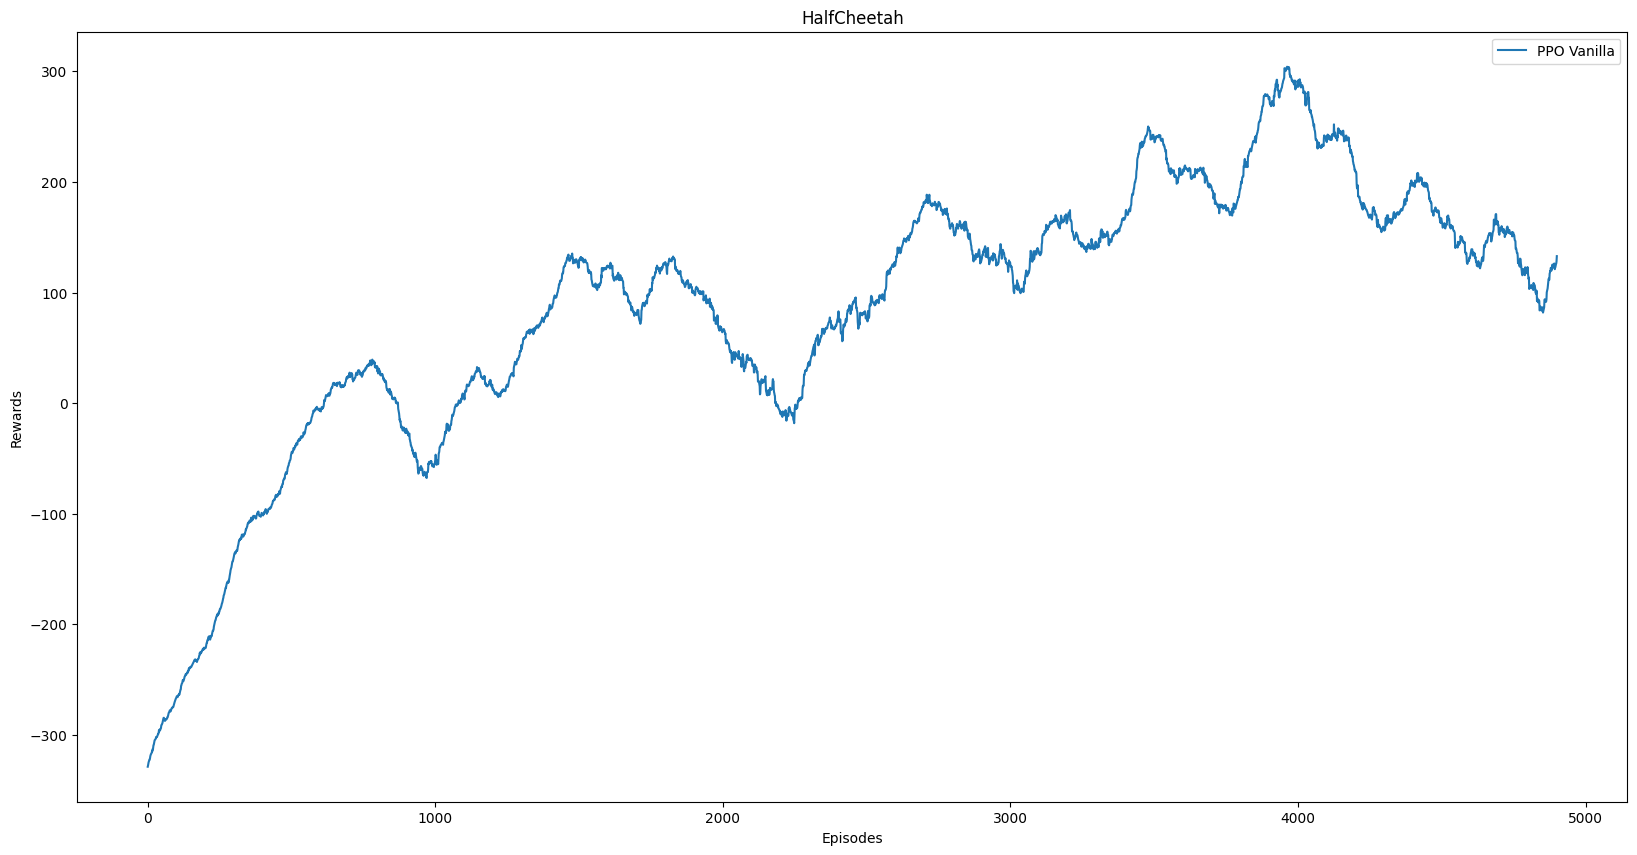

In [20]:
def moving_average(data, window_size):
    """Compute the moving average of a list."""
    return np.convolve(data, np.ones(window_size) / window_size, mode = "valid")

wind_size = 100

plt.figure(figsize = (20, 10))
plt.plot(moving_average(rewards_ppo_cheetah, wind_size), label = "Vanilla PPO")
plt.plot(moving_average(rewards_ppg_cheetah, wind_size), label = "PPG")
# plt.plot(moving_average(rewards_ppg_kl, wind_size), label = "PPG KL")
# plt.plot(moving_average(rewards_ppg_beta, wind_size), label = "PPG Beta")
# plt.plot(moving_average(rewards_ppg_kl_beta, wind_size), label = "PPG KL Beta")
plt.legend()
plt.title("HalfCheetah")
plt.xlabel("Episodes")
plt.ylabel("Rewards")
plt.show()

# save figure as png
# plt.savefig("../doc/fig/comparison_cheetah.png")

Based on these performances, we choose the **PPG with KL divergence** algorithm for the hockey environment as the final model.

## Checkpoint 2: Hockey – learning to handle the puck

In this part, before training my final agent on the cluster, I am trying to see a sensible training behavior, i.e. the reward should increase over time and I am checking the proportion of games I won. I am using the basic opponent for this purpose.

In [2]:
env_hockey = h_env.HockeyEnv_BasicOpponent(mode = Mode.NORMAL, weak_opponent = False)
state_dim = env_hockey.observation_space.shape[0]
action_dim = env_hockey.action_space.shape[0]

#### Vanilla PPO

In [12]:
from src.PPO import PPO

ppo_vanilla = PPO(
    state_dim,
    action_dim,
    n_latent_var = 128,
    lr = 0.0003,
    betas = (0.9, 0.999),
    gamma = 0.99,
    K_epochs = 10,
    eps_clip = 0.25,
    has_continuous_action_space = True,
    action_std_init = 0.5
)

#### PPG

In [13]:
from src.PPG import PPO, Memory

ppg = PPO(
    state_dim,
    action_dim,
    n_latent_var_actor = 128,
    n_latent_var_critic = 128,
    network_depth_actor = 2,
    network_depth_critic = 2,
    has_continuous_action_space = True,
    action_std_init = 0.5,
    lr = 0.0003,
    betas = (0.9, 0.999),
    gamma = 0.99,
    K_epochs = 10,
    eps_clip = 0.25,
    c1 = 0.5,
    c2 = 0.01,
    beta_clone = 0.95
)

#### PPG with KL divergence

In [14]:
from src.PPG_KL import PPO

ppg_kl = PPO(
    state_dim,
    action_dim,
    n_latent_var_actor = 128,
    n_latent_var_critic = 128,
    network_depth_actor = 2,
    network_depth_critic = 2,
    has_continuous_action_space = True,
    action_std_init = 0.5,
    lr = 0.0003,
    betas = (0.9, 0.999),
    gamma = 0.99,
    K_epochs = 10,
    eps_clip = 0.25,
    c1 = 0.5,
    c2 = 0.01,
    beta_clone = 0.95
)

#### PPG with Beta distribution

In [15]:
from src.PPG_Beta import PPO

ppg_beta = PPO(
    state_dim,
    action_dim,
    n_latent_var_actor = 128,
    n_latent_var_critic = 128,
    network_depth_actor = 2,
    network_depth_critic = 2,
    has_continuous_action_space = True,
    action_std_init = 0.5,
    lr = 0.0003,
    betas = (0.9, 0.999),
    gamma = 0.99,
    K_epochs = 10,
    eps_clip = 0.25,
    c1 = 0.5,
    c2 = 0.01,
    beta_clone = 0.95
)

#### PPG with KL divergence and Beta distribution

In [16]:
from src.PPG_KL_Beta import PPO

ppg_kl_beta = PPO(
    state_dim,
    action_dim,
    n_latent_var_actor = 128,
    n_latent_var_critic = 128,
    network_depth_actor = 2,
    network_depth_critic = 2,
    has_continuous_action_space = True,
    action_std_init = 0.5,
    lr = 0.0003,
    betas = (0.9, 0.999),
    gamma = 0.99,
    K_epochs = 10,
    eps_clip = 0.25,
    c1 = 0.5,
    c2 = 0.01,
    beta_clone = 0.95
)

In [9]:
def train_hockey_ppo(env, max_episodes, max_timesteps, update_timestep, aux_phase_freq, agent):
    memory = Memory()
    episode_rewards = []
    info_list = []

    for episode in range(max_episodes):
        done = False
        episode_reward = 0

        # Randomly choose weak or strong opponent
        env = h_env.HockeyEnv(mode = Mode.NORMAL)
        state, _ = env.reset()
        state = state.flatten()
        mode_random = random.choice([True, False])
        player2 = h_env.BasicOpponent(weak = mode_random)
        obs_agent2 = env.obs_agent_two()

        while not done:
            action = agent.policy_old.act(state, memory)

            action_opp = player2.act(obs_agent2)

            next_state, reward, done, _, info = env.step(np.hstack([action, action_opp]))
            next_state = next_state.flatten()

            memory.rewards.append(reward)
            memory.is_terminals.append(done)

            episode_reward += reward
            state = next_state

            obs_agent2 = env.obs_agent_two()

            if done:
                break

        # Auxiliary phase: Train value function
        if episode % aux_phase_freq == 0:
            # agent.auxiliary_phase(memory)
            print(f"Episode {episode + 1}, Reward: {episode_reward}")

        if episode % update_timestep == 0:
            agent.update(memory)
            memory.clear_memory()

        # Log episode results
        episode_rewards.append(episode_reward)
        info_list.append(info.get("winner", None))

        # if episode % checkpoint_freq == 0:
        #     ppo_agent.save_checkpoint(checkpoint_dir, episode)

    return episode_rewards, info_list, agent

In [10]:
def train_hockey_ppg(env, max_episodes, max_timesteps, update_timestep, aux_phase_freq, agent):
    memory = Memory()
    episode_rewards = []
    info_list = []

    for episode in range(max_episodes):
        done = False
        episode_reward = 0

        # Randomly choose weak or strong opponent
        env = h_env.HockeyEnv(mode = Mode.NORMAL)
        state, _ = env.reset()
        state = state.flatten()
        mode_random = random.choice([True, False])
        player2 = h_env.BasicOpponent(weak = mode_random)
        obs_agent2 = env.obs_agent_two()

        while not done:
            action = agent.policy_old.act(state, memory)

            action_opp = player2.act(obs_agent2)

            next_state, reward, done, _, info = env.step(np.hstack([action, action_opp]))
            next_state = next_state.flatten()

            memory.rewards.append(reward)
            memory.is_terminals.append(done)

            episode_reward += reward
            state = next_state

            obs_agent2 = env.obs_agent_two()

            if done:
                break

        # Auxiliary phase: Train value function
        if episode % aux_phase_freq == 0:
            agent.auxiliary_phase(memory)
            print(f"Episode {episode + 1}, Reward: {episode_reward}")

        if episode % update_timestep == 0:
            agent.update(memory)
            memory.clear_memory()

        # Log episode results
        episode_rewards.append(episode_reward)
        info_list.append(info.get("winner", None))

        # if episode % checkpoint_freq == 0:
        #     ppo_agent.save_checkpoint(checkpoint_dir, episode)

    return episode_rewards, info_list, agent

In [11]:
# Train model for 1000 episodes
max_eps = 1000
max_tsteps = 500
upd_tsteps = 500
aux_phase = 50

rewards_ppo, info_ppo, ppo_vanilla = train_hockey_ppo(env_hockey, max_eps, max_tsteps, upd_tsteps, aux_phase, ppo_vanilla)
rewards_ppg, info_ppg, ppg = train_hockey_ppg(env_hockey, max_eps, max_tsteps, upd_tsteps, aux_phase, ppg)
rewards_ppg_kl, info_ppg_kl, ppg_kl = train_hockey_ppg(env_hockey, max_eps, max_tsteps, upd_tsteps, aux_phase, ppg_kl)
rewards_ppg_beta, info_ppg_beta, ppg_beta = train_hockey_ppg(env_hockey, max_eps, max_tsteps, upd_tsteps, aux_phase, ppg_beta)
rewards_ppg_kl_beta, info_ppg_kl_beta, ppg_kl_beta = train_hockey_ppg(env_hockey, max_eps, max_tsteps, upd_tsteps, aux_phase, ppg_kl_beta)

Episode 1, Reward: -15.977991870256844
Episode 51, Reward: -10.01536117120205
Episode 101, Reward: -15.038247239831353


KeyboardInterrupt: 

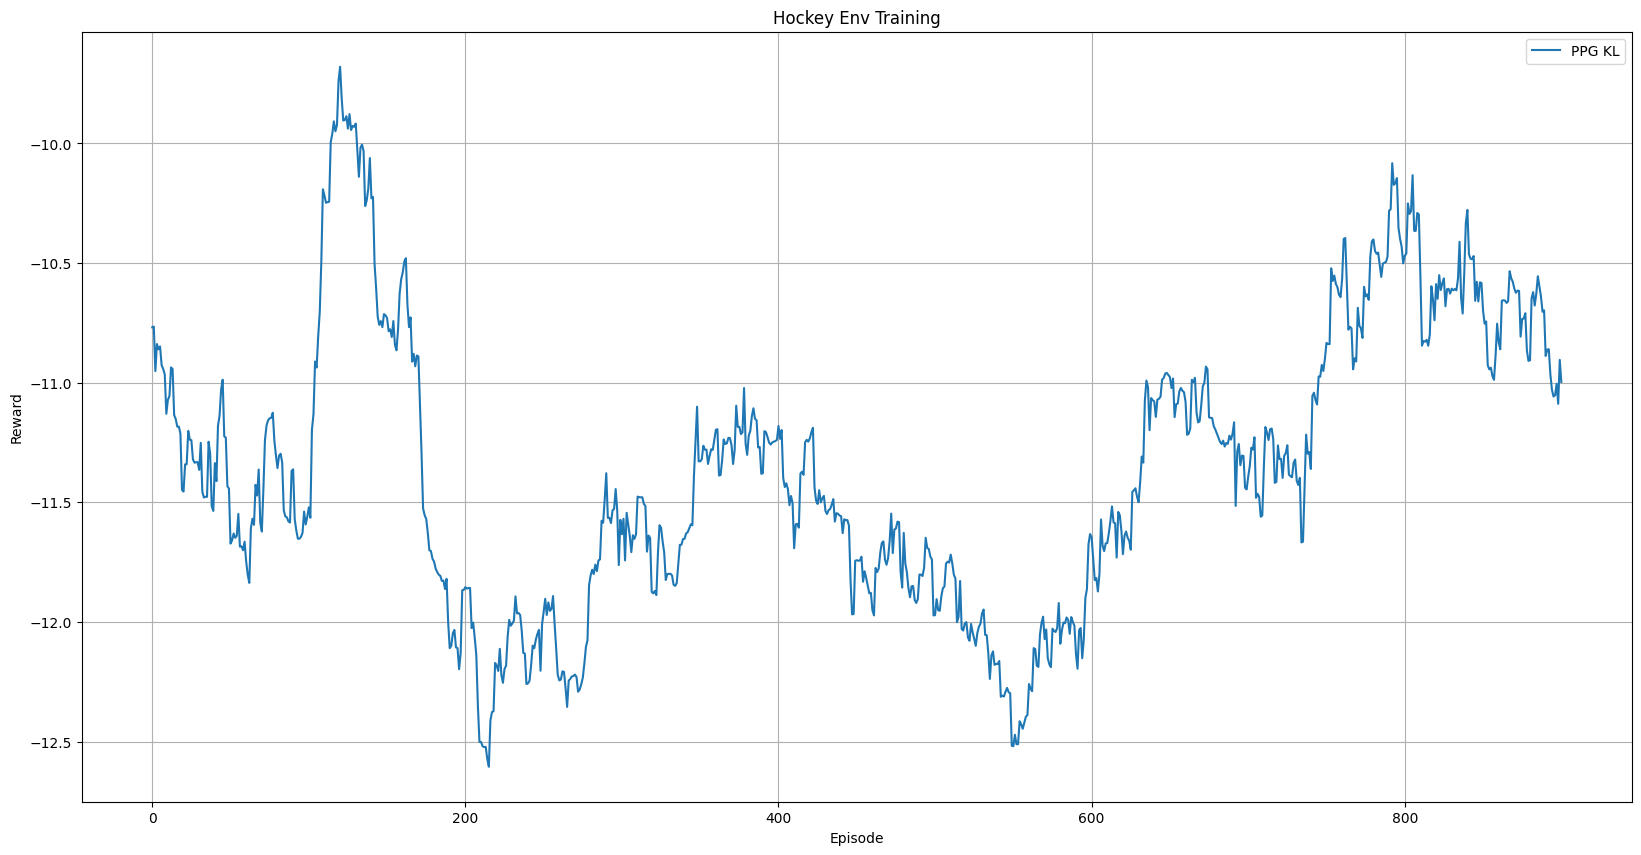

In [11]:
# Plot results
def moving_average(data, window_size):
    """Compute the moving average of a list."""
    return np.convolve(data, np.ones(window_size) / window_size, mode = "valid")

wind_size = 100

plt.figure(figsize = (20, 10))
# plt.plot(moving_average(rewards_ppo, wind_size), label = "PPO Vanilla")
# plt.plot(moving_average(rewards_ppg, wind_size), label = "PPG")
# plt.plot(moving_average(rewards_ppg_gae, wind_size), label = "PPG GAE")
plt.plot(moving_average(rewards_ppg_kl, wind_size), label = "PPG KL")
plt.legend()
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title("Hockey Env Training")
plt.legend()
plt.grid()
plt.show()

Win rate PPO: 0.08, Win rate PPG: 0.088, Win rate PPG GAE: 0.087, Win rate PPG KL: 0


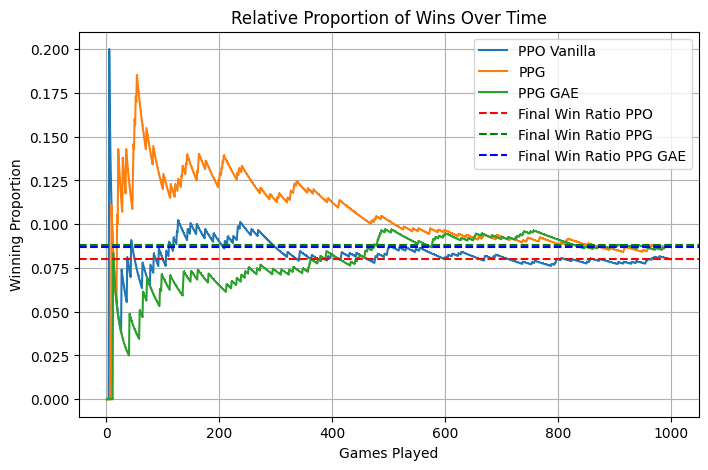

In [19]:
# Plot win rate for every agent
# calculate the number of 0,-1, 1 for each episode and divide by the number of episodes
num_episodes = len(info_ppo)

num_wins_ppo = np.sum(np.array(info_ppo) == 1)
# num_wins_ppg = np.sum(np.array(info_ppg) == 1)
num_wins_ppg_gae = np.sum(np.array(info_ppg_gae) == 1)
num_wins_ppg_kl = np.sum(np.array(info_ppg_kl) == 1)

ratio_wins_ppo = round(num_wins_ppo / num_episodes, 3)
# ratio_wins_ppg = round(num_wins_ppg / num_episodes, 3)
ratio_wins_ppg_gae = round(num_wins_ppg_gae / num_episodes, 3)
ratio_wins_ppg_kl = round(num_wins_ppg_kl / num_episodes, 3)
ratio_wins_ppg_kl = 0

print(f"Win rate PPO: {ratio_wins_ppo}, Win rate PPG: {ratio_wins_ppg_gae}, Win rate PPG GAE: {ratio_wins_ppg_gae}, Win rate PPG KL: {ratio_wins_ppg_kl}")

info_array_ppo = np.array(info_ppo)
# info_array_ppg = np.array(info_ppg)
info_array_ppg_gae = np.array(info_ppg_gae)
info_array_ppg_kl = np.array(info_ppg_kl)

games_played = np.arange(1, len(info_ppo) + 1)

wins_ppo = np.cumsum(info_array_ppo == 1)
# wins_ppg = np.cumsum(info_array_ppg == 1)
wins_ppg_gae = np.cumsum(info_array_ppg_gae == 1)
wins_ppg_kl = np.cumsum(info_array_ppg_kl == 1)

win_ratio_ppo = wins_ppo / games_played
# win_ratio_ppg = wins_ppg / games_played
win_ratio_ppg_gae = wins_ppg_gae / games_played
win_ratio_ppg_kl = wins_ppg_kl / games_played

plt.figure(figsize = (8, 5))
plt.plot(games_played, win_ratio_ppo, marker = ',', linestyle = '-', label = "PPO Vanilla")
# plt.plot(games_played, win_ratio_ppg, marker = ',', linestyle = '-', label = "PPG")
plt.plot(games_played, win_ratio_ppg_gae, marker = ',', linestyle = '-', label = "PPG")
plt.plot(games_played, win_ratio_ppg_kl, marker = ',', linestyle = '-', label = "PPG KL")
plt.axhline(y = ratio_wins_ppo, color = 'r', linestyle = '--', label = "Final Win Ratio PPO")
# plt.axhline(y = ratio_wins_ppg, color = 'g', linestyle = '--', label = "Final Win Ratio PPG")
plt.axhline(y = ratio_wins_ppg_gae, color = 'b', linestyle = '--', label = "Final Win Ratio PPG GAE")
plt.axhline(y = ratio_wins_ppg_kl, color = 'y', linestyle = '--', label = "Final Win Ratio PPG KL")
plt.xlabel("Games Played")
plt.ylabel("Winning Proportion")
plt.title("Relative Proportion of Wins Over Time")
plt.legend()
plt.grid(True)
plt.show()

Win rate: 0.055, Loss rate: 0.055, Tie rate: 0.211


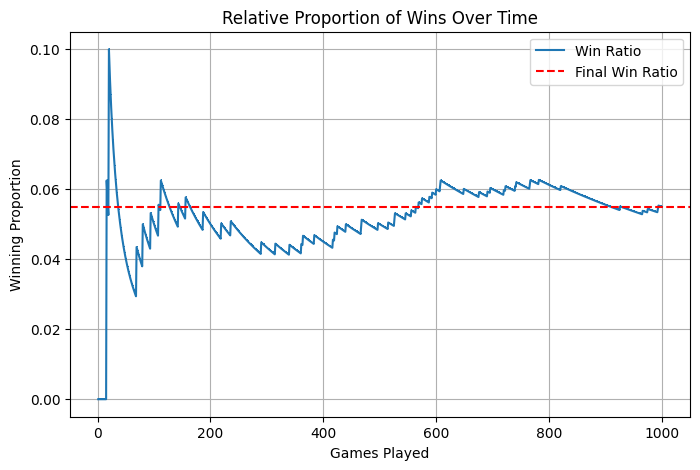

In [16]:
# Plot win rate
# calculate the number of 0,-1, 1 for each episode and divide by the number of episodes
num_episodes = len(info_ppo)

num_ties = np.sum(np.array(info_ppo) == 0)
num_wins = np.sum(np.array(info_ppo) == 1)
num_losses = np.sum(np.array(info_ppo) == -1)

ratio_ties = round(num_ties / num_episodes, 3)
ratio_wins = round(num_wins/ num_episodes, 3)
ratio_losses = round(num_wins / num_episodes, 3)

print(f"Win rate: {ratio_wins}, Loss rate: {ratio_losses}, Tie rate: {ratio_ties}")

info_array = np.array(info_ppo)
games_played = np.arange(1, len(info_ppo) + 1)
wins = np.cumsum(info_array == 1)
win_ratio = wins / games_played

plt.figure(figsize = (8, 5))
plt.plot(games_played, win_ratio, marker = ',', linestyle = '-', label = "Win Ratio")
plt.axhline(y = ratio_wins, color = 'r', linestyle = '--', label = "Final Win Ratio")
plt.xlabel("Games Played")
plt.ylabel("Winning Proportion")
plt.title("Relative Proportion of Wins Over Time")
plt.legend()
plt.grid(True)
plt.show()

In [24]:
ppg_KL.save_checkpoint("ppg_KL", 1000)

Checkpoint saved at ppg_KL/checkpoint_1000.pth


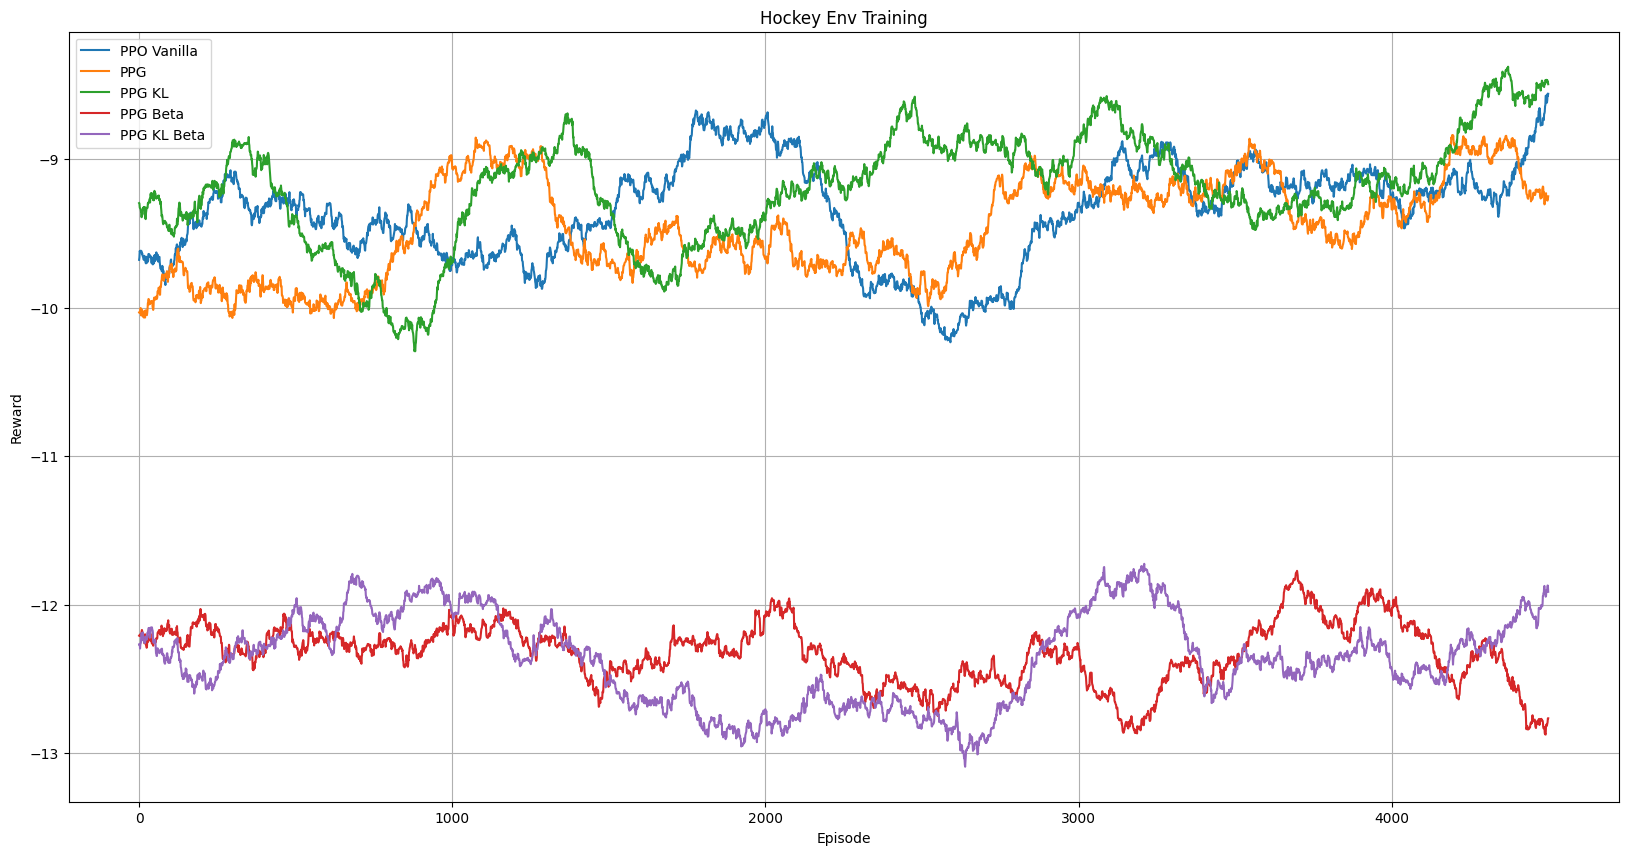

In [37]:
rewards_ppo = np.load("../dat/hockey/rewards_ppo.npy")
rewards_ppg_gae = np.load("../dat/hockey/rewards_ppg_gae.npy")
rewards_ppg_kl = np.load("../dat/hockey/rewards_ppg_kl.npy")
rewards_ppg_beta = np.load("../dat/hockey/rewards_ppg_beta.npy")
rewards_ppg_kl_beta = np.load("../dat/hockey/rewards_ppg_kl_beta.npy")

# Plot results
def moving_average(data, window_size):
    """Compute the moving average of a list."""
    return np.convolve(data, np.ones(window_size) / window_size, mode = "valid")

wind_size = 500

plt.figure(figsize = (20, 10))
plt.plot(moving_average(rewards_ppo, wind_size), label = "PPO Vanilla")
# plt.plot(moving_average(rewards_ppg, wind_size), label = "PPG")
plt.plot(moving_average(rewards_ppg_gae, wind_size), label = "PPG")
plt.plot(moving_average(rewards_ppg_kl, wind_size), label = "PPG KL")
plt.plot(moving_average(rewards_ppg_beta, wind_size), label = "PPG Beta")
plt.plot(moving_average(rewards_ppg_kl_beta, wind_size), label = "PPG KL Beta")
plt.legend()
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title("Hockey Env Training")
plt.legend()
plt.grid()
plt.show()

In [38]:
# calc average reward
def average_reward(rewards):
    return np.round(np.mean(rewards))

print("PPO Vanilla: ", average_reward(rewards_ppo))
print("PPG: ", average_reward(rewards_ppg_gae))
print("PPG KL: ", average_reward(rewards_ppg_kl))
print("PPG Beta: ", average_reward(rewards_ppg_beta))
print("PPG KL Beta: ", average_reward(rewards_ppg_kl_beta))

PPO Vanilla:  -9.0
PPG:  -9.0
PPG KL:  -9.0
PPG Beta:  -12.0
PPG KL Beta:  -12.0


In [34]:
info_ppo = np.load("../dat/hockey/info_ppo.npy")
# info_ppg = np.load("cluster/info_ppg.npy")
info_ppg_gae = np.load("../dat/hockey/info_ppg_gae.npy")
info_ppg_kl = np.load("../dat/hockey/info_ppg_kl.npy")
info_ppg_beta = np.load("../dat/hockey/info_ppg_beta.npy")
info_ppg_kl_beta = np.load("../dat/hockey/info_ppg_kl_beta.npy")

Win rate PPO: 0.114, Win rate PPG GAE: 0.123, Win rate PPG KL: 0.081, Win rate PPG Beta: 0.049, Win rate PPG KL Beta: 0.052


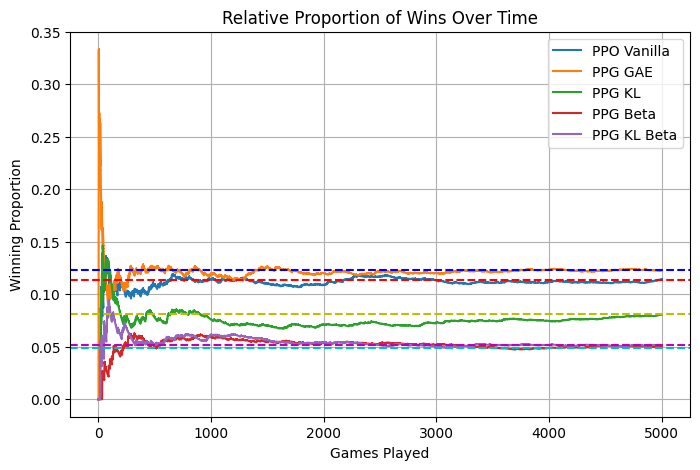

In [35]:
# Plot win rate for every agent
# calculate the number of 0,-1, 1 for each episode and divide by the number of episodes
num_episodes = len(info_ppo)

num_wins_ppo = np.sum(np.array(info_ppo) == 1)
# num_wins_ppg = np.sum(np.array(info_ppg) == 1)
num_wins_ppg_gae = np.sum(np.array(info_ppg_gae) == 1)
num_wins_ppg_kl = np.sum(np.array(info_ppg_kl) == 1)
num_wins_ppg_beta = np.sum(np.array(info_ppg_beta) == 1)
num_wins_ppg_kl_beta = np.sum(np.array(info_ppg_kl_beta) == 1)

ratio_wins_ppo = round(num_wins_ppo / num_episodes, 3)
# ratio_wins_ppg = round(num_wins_ppg / num_episodes, 3)
ratio_wins_ppg_gae = round(num_wins_ppg_gae / num_episodes, 3)
ratio_wins_ppg_kl = round(num_wins_ppg_kl / num_episodes, 3)
ratio_wins_ppg_beta = round(num_wins_ppg_beta / num_episodes, 3)
ratio_wins_ppg_kl_beta = round(num_wins_ppg_kl_beta / num_episodes, 3)

print(f"Win rate PPO: {ratio_wins_ppo}, Win rate PPG GAE: {ratio_wins_ppg_gae}, Win rate PPG KL: {ratio_wins_ppg_kl}, Win rate PPG Beta: {ratio_wins_ppg_beta}, Win rate PPG KL Beta: {ratio_wins_ppg_kl_beta}")

info_array_ppo = np.array(info_ppo)
# info_array_ppg = np.array(info_ppg)
info_array_ppg_gae = np.array(info_ppg_gae)
info_array_ppg_kl = np.array(info_ppg_kl)
info_array_ppg_beta = np.array(info_ppg_beta)
info_array_ppg_kl_beta = np.array(info_ppg_kl_beta)

games_played = np.arange(1, len(info_ppo) + 1)

wins_ppo = np.cumsum(info_array_ppo == 1)
# wins_ppg = np.cumsum(info_array_ppg == 1)
wins_ppg_gae = np.cumsum(info_array_ppg_gae == 1)
wins_ppg_kl = np.cumsum(info_array_ppg_kl == 1)
wins_ppg_beta = np.cumsum(info_array_ppg_beta == 1)
wins_ppg_kl_beta = np.cumsum(info_array_ppg_kl_beta == 1)

win_ratio_ppo = wins_ppo / games_played
# win_ratio_ppg = wins_ppg / games_played
win_ratio_ppg_gae = wins_ppg_gae / games_played
win_ratio_ppg_kl = wins_ppg_kl / games_played
win_ratio_ppg_beta = wins_ppg_beta / games_played
win_ratio_ppg_kl_beta = wins_ppg_kl_beta / games_played

plt.figure(figsize = (8, 5))
plt.plot(games_played, win_ratio_ppo, marker = ',', linestyle = '-', label = "PPO Vanilla")
# plt.plot(games_played, win_ratio_ppg, marker = ',', linestyle = '-', label = "PPG")
plt.plot(games_played, win_ratio_ppg_gae, marker = ',', linestyle = '-', label = "PPG GAE")
plt.plot(games_played, win_ratio_ppg_kl, marker = ',', linestyle = '-', label = "PPG KL")
plt.plot(games_played, win_ratio_ppg_beta, marker = ',', linestyle = '-', label = "PPG Beta")
plt.plot(games_played, win_ratio_ppg_kl_beta, marker = ',', linestyle = '-', label = "PPG KL Beta")
plt.axhline(y = ratio_wins_ppo, color = 'r', linestyle = '--')
# plt.axhline(y = ratio_wins_ppg, color = 'g', linestyle = '--')
plt.axhline(y = ratio_wins_ppg_gae, color = 'b', linestyle = '--')
plt.axhline(y = ratio_wins_ppg_kl, color = 'y', linestyle = '--')
plt.axhline(y = ratio_wins_ppg_beta, color = 'c', linestyle = '--')
plt.axhline(y = ratio_wins_ppg_kl_beta, color = 'm', linestyle = '--')
plt.xlabel("Games Played")
plt.ylabel("Winning Proportion")
plt.title("Relative Proportion of Wins Over Time")
plt.legend()
plt.grid(True)
plt.show()

## Evaluation

Testing the final agent on the hockey environment with a basic opponent: weak and strong.

In [39]:
rewards_ppg_kl = np.load("../dat/hockey/rewards_ppg_kl.npy")
info_ppg_kl = np.load("../dat/hockey/info_ppg_kl.npy")

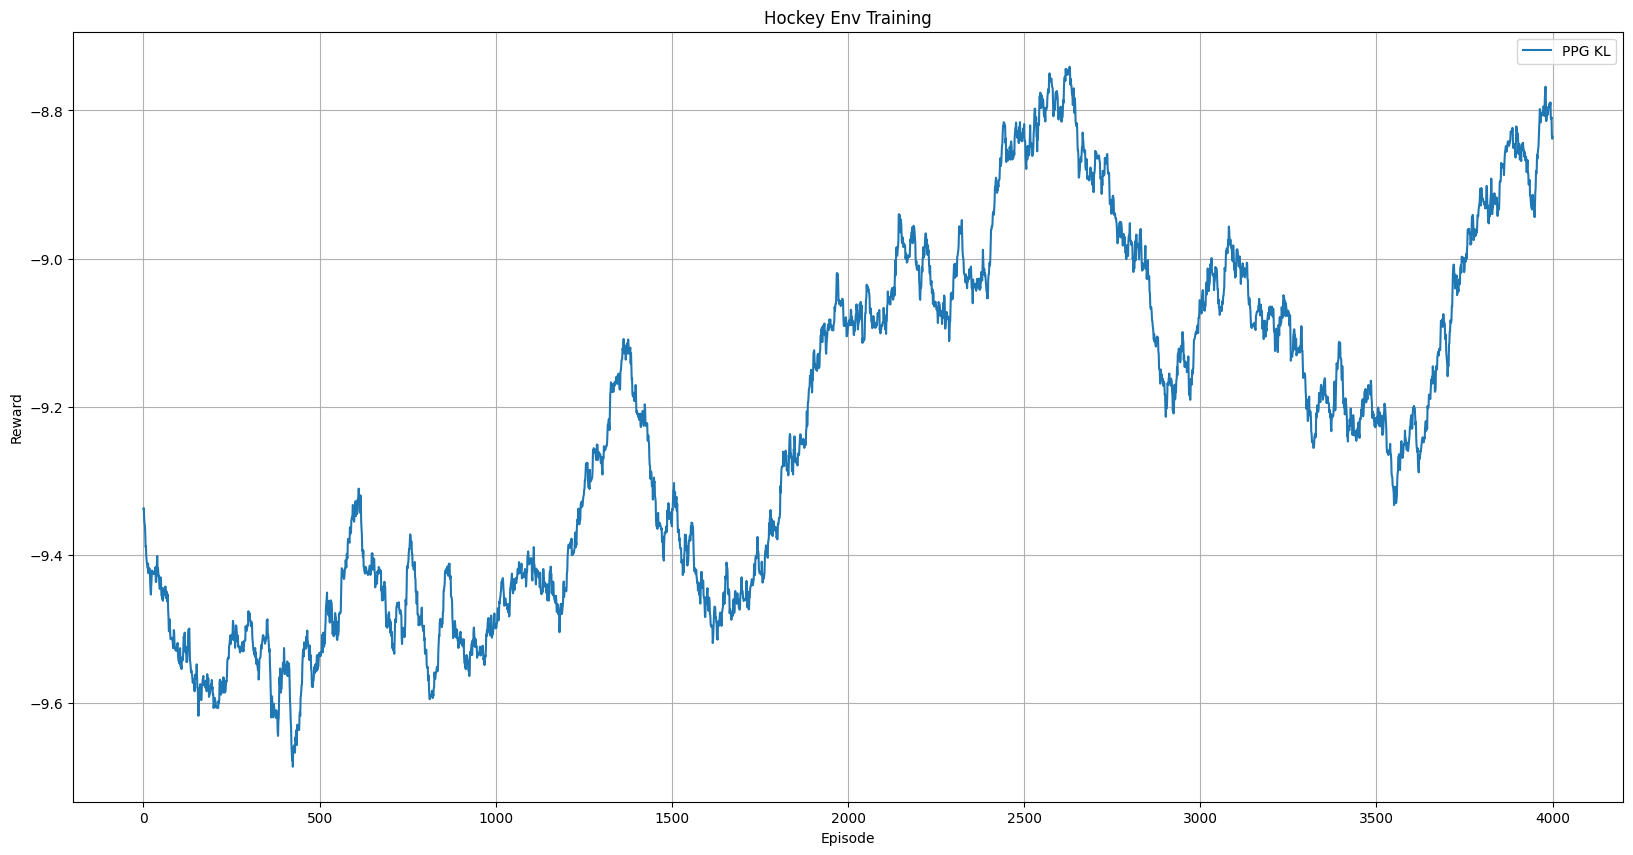

In [40]:
# Plot results
def moving_average(data, window_size):
    """Compute the moving average of a list."""
    return np.convolve(data, np.ones(window_size) / window_size, mode = "valid")

wind_size = 1000

plt.figure(figsize = (20, 10))
plt.plot(moving_average(rewards_ppg_kl, wind_size), label = "PPG KL")
plt.legend()
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title("Hockey Env Training")
plt.legend()
plt.grid()
plt.show()

Win rate PPG KL: 0.081


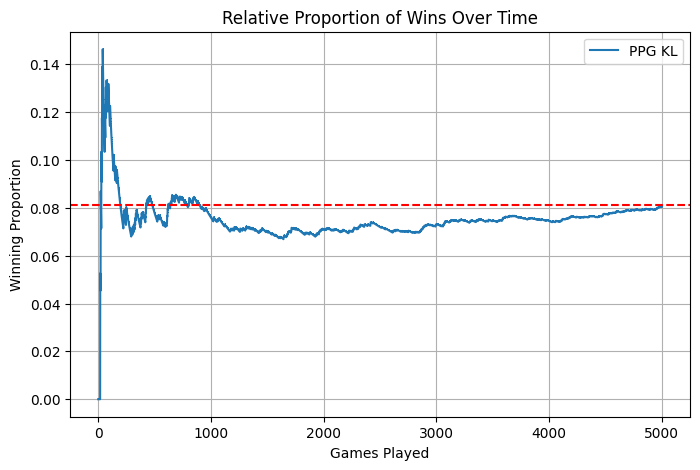

In [12]:
# plot win rate
# calculate the number of 0,-1, 1 for each episode and divide by the number of episodes
num_episodes = len(info_ppg_kl)

num_wins_ppg_kl = np.sum(np.array(info_ppg_kl) == 1)

ratio_wins_ppg_kl = round(num_wins_ppg_kl / num_episodes, 3)

print(f"Win rate PPG KL: {ratio_wins_ppg_kl}")

info_array_ppg_kl = np.array(info_ppg_kl)

games_played = np.arange(1, len(info_ppg_kl) + 1)

wins_ppg_kl = np.cumsum(info_array_ppg_kl == 1)

win_ratio_ppg_kl = wins_ppg_kl / games_played

plt.figure(figsize = (8, 5))
plt.plot(games_played, win_ratio_ppg_kl, marker = ',', linestyle = '-', label = "PPG KL")
plt.axhline(y = ratio_wins_ppg_kl, color = 'r', linestyle = '--')
plt.xlabel("Games Played")
plt.ylabel("Winning Proportion")
plt.title("Relative Proportion of Wins Over Time")
plt.legend()
plt.grid(True)
plt.show()

In [24]:
def test_agent(number_games, weak_mode, agent):
    winner_list = np.zeros(number_games)
    rewards = 0
    env = h_env.HockeyEnv(mode = Mode.NORMAL)
    memory = None

    for i in range(number_games):

        state, _ = env.reset()
        state = state.flatten()
        player2 = h_env.BasicOpponent(weak = weak_mode)
        obs_agent2 = env.obs_agent_two()

        for t in range(500):

            action = agent.policy_old.act(state, memory)

            action_opp = player2.act(obs_agent2)

            next_state, reward, done, _, info = env.step(np.hstack([action, action_opp]))
            next_state = next_state.flatten()

            state = next_state

            obs_agent2 = env.obs_agent_two()

            rewards += reward
            if done:
                winner_list[i] = info["winner"]
                break

    print("Wins: ", np.sum(winner_list == 1), "wins")
    print("Draws: ", np.sum(winner_list == 0), "draws")
    print("Losses: ", np.sum(winner_list == -1), "losses")
    print("Winning rate: ", np.round(np.sum(winner_list == 1) / number_games, 3))
    print("Avg. reward: ", np.round(rewards / number_games))

In [29]:
# load checkpoint
from src.PPG_KL import PPO
ppg_KL = PPO(
    18,
    4,
    n_latent_var_actor = 128,
    n_latent_var_critic = 128,
    network_depth_actor = 2,
    network_depth_critic = 2,
    has_continuous_action_space = True,
    action_std_init = 0.5,
    lr = 0.0003,
    betas = (0.9, 0.999),
    gamma = 0.99,
    K_epochs = 10,
    eps_clip = 0.25,
    c1 = 0.5,
    c2 = 0.01,
    beta_clone = 0.95
)

ppg_KL.load_checkpoint("cluster/checkpoint_100000.pth")

Loaded checkpoint from cluster/checkpoint_100000.pth


In [30]:
# Test agent
number_games = 200
weak_mode = True

print("Weak Opponent")
test_agent(number_games, weak_mode, ppg_KL)

weak_mode = False
print("\nStrong Opponent")
test_agent(number_games, weak_mode, ppg_KL)

Weak Opponent
Wins:  33 wins
Draws:  118 draws
Losses:  49 losses
Winning rate:  0.165
Avg. reward:  -7.0

Strong Opponent
Wins:  46 wins
Draws:  63 draws
Losses:  91 losses
Winning rate:  0.23
Avg. reward:  -7.0
